In [26]:
# Gurobi for optimization
from gurobipy import GRB, Model, quicksum
import gurobipy as gp

# Pandas for data manipulation
import pandas as pd

# Numpy for numerical operations
import numpy as np

# Matplotlib for visualization
import matplotlib.pyplot as plt

# Datetime for handling time-related data
import datetime

# Pickle for saving/loading objects (optional, based on need)
import pickle

In [27]:
# # Seed for reproducibility
np.random.seed(46)

# Generate flight data
flight_ids = [f"F{i:02d}" for i in range(1, 26)]
arrival_times = ['09:00', '08:30', '09:00', '08:30', '08:15',
                 '07:30', '10:15', '10:00', '10:25', '10:40',
                 '11:00', '11:00', '11:15', '9:30', '11:30',
                 '12:00', '11:45', '11:50', '12:55', '12:10',
                 '12:45', '7:35', '12:10', '9:20', '8:20']

departure_times = ['09:50', '09:10', '09:50', '10:20', '09:00',
                   '08:50', '11:20', '10:50', '11:55', '11:35',
                   '12:35', '12:25', '12:15', '10:20', '12:40',
                   '13:55', '13:40', '12:45', '13:55', '14:00',
                   '14:30', '9:00', '13:30', '11:20', '9:40']

passenger_numbers = [140, 138, 340, 293, 252,
                     105, 130, 166, 191, 178,
                     293, 166, 255, 183, 176,
                     220, 173, 145, 118, 153,
                     256, 104, 269, 140, 142]

flight_types = ['Domestic', 'Domestic', 'International', 'International', 'International',
                'Domestic', 'Domestic', 'Domestic', 'International', 'Domestic',
                'International', 'Domestic', 'International', 'International', 'Domestic',
                'International', 'Domestic', 'Domestic', 'Domestic', 'Domestic',
                'International', 'Domestic', 'International', 'Domestic', 'Domestic']

# Convert times to minutes since midnight for consistency with previous code
def time_to_minutes(t):
    h, m = map(int, t.split(':'))
    return h * 60 + m

arrival_times = [time_to_minutes(t) for t in arrival_times]
departure_times = [time_to_minutes(t) for t in departure_times]

flight_data = pd.DataFrame({
    'flight_id': flight_ids,
    'arrival_time': arrival_times,
    'departure_time': departure_times,
    'passenger_number': passenger_numbers,
    'flight_type': flight_types
})

# Generate gate data
gate_ids = [f"Gate {i}" for i in range(1, 7)]
gate_types = ['Domestic', 'Domestic', 'International', 'International', 'International', 'International']

gate_data = pd.DataFrame({
    'gate_id': gate_ids,
    'gate_type': gate_types
})

# Calculate distances between gates (d_kl) and from gates to entrance/exit (ed_k)
distances = [
    [0, 2, 4, 4, 6, 8],
    [2, 0, 2, 6, 8, 10],
    [4, 2, 0, 8, 10, 12],
    [4, 6, 8, 0, 2, 4],
    [6, 8, 10, 2, 0, 2],
    [8, 10, 12, 4, 2, 0]
]

# Increase distances by a factor of 100
distance_df = pd.DataFrame(distances, index=gate_ids, columns=gate_ids)

# Increase distances to entrance/exit by a factor of 100
ed_k = [3, 5, 7, 3, 5, 7]

# Store number of flights and gates
num_flights = len(flight_data)
num_gates = len(gate_data)

# Generate transiting passengers data (p_ij) with constraints
p_ij = np.zeros((num_flights, num_flights), dtype=int)

for i in range(num_flights):
    max_transit_passengers = passenger_numbers[i] // 2  # Maximum of 50% of the total passengers
    remaining_passengers = max_transit_passengers
    transfer_flights = np.random.choice([x for x in range(num_flights) if x != i], 3, replace=False)  # Choose 2 different flights
    for j in transfer_flights:
        if remaining_passengers > 0:
            p_ij[i, j] = np.random.randint(0, min(50, remaining_passengers + 1))
            remaining_passengers -= p_ij[i, j]
            
# Second pass to ensure inflow constraints are met
for j in range(num_flights):
    total_inflow = sum(p_ij[i, j] for i in range(num_flights))
    if total_inflow > passenger_numbers[j]:
        excess_passengers = total_inflow - passenger_numbers[j]
        inflow_flights = [i for i in range(num_flights) if p_ij[i, j] > 0]
        
        while excess_passengers > 0 and inflow_flights:
            i = inflow_flights.pop()
            reduction = min(p_ij[i, j], excess_passengers)
            p_ij[i, j] -= reduction
            excess_passengers -= reduction

# # Verify generated data
# print("Flight Data:")
# print(flight_data.head(num_flights))

# print("\nGate Data:")
# print(gate_data.head(num_gates))

# print("\nDistance Matrix (d_kl):")
# print(distance_df)

# print("\nDistance to Entrance/Exit (ed_k):")
# print(pd.Series(ed_k, index=gate_ids))

# print("\nTransiting Passengers (p_ij):")
# print(pd.DataFrame(p_ij, index=flight_ids, columns=flight_ids).head(num_flights))

### Model Explanation

The objective of the FC formulation is to minimize the total walking distance of passengers at the airport, considering both transfer passengers and non-transfer passengers. The model includes the following key components:

- **Parameters**:
  - `num_flights`: Number of flights
  - `num_gates`: Number of gates
  - `arrival_times`: Arrival times of flights
  - `departure_times`: Departure times of flights
  - `passenger_numbers`: Number of passengers per flight
  - `flight_types`: Type of flight (domestic/international)
  - `gate_types`: Type of gate (domestic/international)
  - `distances`: Distance matrix between gates

- **Decision Variables**:
  - `x[i, k]`: Binary variable, 1 if flight \(i\) is assigned to gate \(k\), 0 otherwise
  - `w[i, k, l]`: Continuous variable representing the number of passengers from flight \(i\) through gate \(k\) to gate \(l\)

- **Objective Function**:
  - Minimize the total walking distance of passengers.

- **Constraints**:
  - Each flight must be assigned to exactly one gate.
  - Gates cannot be double-booked.
  - Flow balance constraints for transfer passengers.

In [28]:
# Initialize the Gurobi model
model = Model("FC_Formulation")

# Distance penalty for the apron
apron_distance_penalty = 30

# Distance matrices
d_kl = np.zeros((num_gates + 1, num_gates + 1))
d_kl[:num_gates, :num_gates] = distance_df.values
d_kl[num_gates, :] = apron_distance_penalty  # Distance from apron to all gates
d_kl[:, num_gates] = apron_distance_penalty  # Distance from all gates to apron
d_kl[num_gates, num_gates] = apron_distance_penalty  # Distance from apron to itself

# Distance to/from exit for each gate (including apron)
ed_k = np.append(ed_k, apron_distance_penalty)  # Append apron distance to exit

# print(d_kl,ed_k)
# Passengers data
e_i = flight_data['passenger_number'].values - np.sum(p_ij, axis=1)
f_i = flight_data['passenger_number'].values - np.sum(p_ij, axis=0)

# Aircraft type (domestic/international)
g_i = flight_data['flight_type'].apply(lambda x: 'D' if x == 'Domestic' else 'I').values

# Sets of domestic and international gates
K_D = [k for k, t in zip(range(num_gates), gate_types) if t == 'Domestic']
K_I = [k for k, t in zip(range(num_gates), gate_types) if t == 'International']
K_D.append(num_gates)  # Add apron to domestic gates
K_I.append(num_gates)  # Add apron to international gates

# Number of gates
m = num_gates

# Generating overlap sets for all time steps
def generate_overlap_sets(flight_data):
    # Initialize dictionaries to hold overlap sets
    I_Dt = []
    I_It = []
    T_D = {}
    T_I = {}
    
    # Iterate through each minute of the day
    for t in range(1440):
        domestic_overlaps = set()
        international_overlaps = set()
        
        # Check for overlapping flights at time t
        for i, flight in flight_data.iterrows():
            if flight['arrival_time'] <= t < flight['departure_time']:
                if flight['flight_type'] == 'Domestic':
                    domestic_overlaps.add(flight['flight_id'])
                else:
                    international_overlaps.add(flight['flight_id'])
        
        if domestic_overlaps:
            I_Dt.append(domestic_overlaps)
        if international_overlaps:
            I_It.append(international_overlaps)
    
    # Convert I_Dt and I_It to T_D and T_I
    for idx, overlap_set in enumerate(I_Dt):
        if overlap_set:
            T_D[f"TD{idx+1}"] = overlap_set
            
    for idx, overlap_set in enumerate(I_It):
        if overlap_set:
            T_I[f"TI{idx+1}"] = overlap_set
    
    return T_D, T_I

# Generate overlap sets
T_D, T_I = generate_overlap_sets(flight_data)

# # Print overlap sets
# print("Overlap Sets for Domestic Flights (T_D):")
# for key, value in T_D.items():
#     print(f"{key}: {value}")

# print("\nOverlap Sets for International Flights (T_I):")
# for key, value in T_I.items():
#     print(f"{key}: {value}")

# Decision Variables
x = model.addVars(num_flights, num_gates + 1, vtype=GRB.BINARY, name="x")
w = model.addVars(num_flights, num_gates + 1, num_gates + 1, vtype=GRB.CONTINUOUS, name="w")

# Verify variables
print("Decision variables defined.")

Decision variables defined.


In [29]:
# Objective function components\n",
objective = quicksum(d_kl[k, l] * w[i, k, l] for i in range(num_flights) for k in range(num_gates + 1) for l in range(num_gates + 1)) + \
            quicksum((e_i[i] + f_i[i]) * ed_k[k] * x[i, k] for i in range(num_flights) for k in range(num_gates + 1))

model.setObjective(objective, GRB.MINIMIZE)

# Verify objective
print("Objective function defined.")

Objective function defined.


In [30]:
# Constraint 3: Assign each aircraft to exactly one gate
for i in range(num_flights):
    if g_i[i] == 'D':
        model.addConstr(quicksum(x[i, k] for k in K_D) == 1, name=f"Assign_Domestic_{i}")
    else:
        model.addConstr(quicksum(x[i, k] for k in K_I) == 1, name=f"Assign_International_{i}")

# Add Constraints (4) and (5): At most one aircraft can be assigned to a fixed gate during a certain time interval
# Constraint (4) for domestic flights (excluding apron)
for t, I_Dt in T_D.items():
    for k in K_D[:-1]:  # Exclude the apron
        model.addConstr(quicksum(x[flight_ids.index(flight), k] for flight in I_Dt) <= 1, name=f"MaxOneAircraft_Domestic_{t}_Gate{k}")

# Constraint (5) for international flights (excluding apron)
for t, I_It in T_I.items():
    for k in K_I[:-1]:  # Exclude the apron
        model.addConstr(quicksum(x[flight_ids.index(flight), k] for flight in I_It) <= 1, name=f"MaxOneAircraft_International_{t}_Gate{k}")

# Constraint 6: Minimum apron assignments
# model.addConstr(quicksum(x[i, num_gates] for i in range(num_flights)) <= 5, name="min_apron_assignments")

# Constraint (10): Passenger flow balance constraints (outbound)
for i in range(num_flights):
    gate_set = K_D if g_i[i] == 'D' else K_I  # Select the appropriate gate set
    for k in gate_set:
        model.addConstr(
            quicksum(w[i, k, l] for l in range(num_gates + 1)) == x[i, k] * sum(p_ij[i, j] for j in range(num_flights)),
            name=f"FlowBalance_{i}_{k}"
        )

# Constraint 11: Passenger flow balance constraints (inbound)
for i in range(num_flights):
    gate_set = K_D if g_i[i] == 'D' else K_I  # Select the appropriate gate set
    for k in range(num_gates + 1):  # Iterate over all gates including the apron
        model.addConstr(
            quicksum(w[i, l, k] for l in gate_set) == 
            quicksum(p_ij[i, j] * x[j, k] for j in range(num_flights)),
            name=f"PassengerFlow_{i}_{k}"
        )

# Constraint 12: Non-negativity of flow variables
for i in range(num_flights):
    gate_set = K_D if g_i[i] == 'D' else K_I  # Select the appropriate gate set
    for k in gate_set:
        for l in range(num_gates + 1):  # Iterate over all gates including the apron
            model.addConstr(
                w[i, k, l] >= 0,
                name=f"NonNegativeFlow_{i}_{k}_{l}"
            )

# Constraint (13): Ensure that overlapping domestic aircraft are assigned to the apron
for t, I_Dt in T_D.items():
    if len(I_Dt) > len(K_D) - 1:  # K_D includes the apron, so len(K_D) - 1 is the number of fixed gates
        model.addConstr(
            quicksum(x[flight_ids.index(flight), num_gates] for flight in I_Dt) >= len(I_Dt) - (len(K_D) - 1),
            name=f"ApronAssignment_Domestic_{t}"
        )

# Constraint (14): Ensure that overlapping international aircraft are assigned to the apron
for t, I_It in T_I.items():
    if len(I_It) > len(K_I) - 1:  # K_I includes the apron, so len(K_I) - 1 is the number of fixed gates
        model.addConstr(
            quicksum(x[flight_ids.index(flight), num_gates] for flight in I_It) >= len(I_It) - (len(K_I) - 1),
            name=f"ApronAssignment_International_{t}"
         )

# Verify constraints
print("Constraints defined.")

Constraints defined.


In [31]:
# # Optimize model
# model.optimize()

# flight_assignments = {}
# # Print results
# if model.status == GRB.OPTIMAL:
#     # Print flight assignments to gates
#     for i in range(num_flights):
#         for k in range(num_gates + 1):
#             if x[i, k].X > 0.5:  # Check if the flight is assigned to the gate
#                 flight_assignments[f"F{i+1:02d}"] = k + 1  # Store gate number (1-indexed)
#                 gate = 'Apron' if k == num_gates else gate_ids[k]
#                 print(f"Flight {flight_data.loc[i, 'flight_id']} is assigned to {gate}")
    
#     # Print the flow of passengers between gates and to the exit
#     print("\nPassenger Flow Between Gates and to the Exit:")
#     for i in range(num_flights):
#         for k in range(num_gates + 1):
#             gate_from = 'Apron' if k == num_gates else gate_ids[k]
#             total_transfer_passengers = 0
#             # Flow to other gates
#             for l in range(num_gates + 1):
#                 if w[i, k, l].X > 0:  # Only print non-zero flows
#                     gate_to = 'Apron' if l == num_gates else gate_ids[l]
#                     print(f"Flow from Flight {flight_data.loc[i, 'flight_id']} at {gate_from} to {gate_to}: {w[i, k, l].X}")
#                     total_transfer_passengers += w[i, k, l].X
#             # Flow to exit
#             if x[i, k].X > 0.5:
#                 passengers_to_exit = flight_data.loc[i, 'passenger_number'] - total_transfer_passengers
#                 if passengers_to_exit > 0:
#                     print(f"Flow from Flight {flight_data.loc[i, 'flight_id']} at {gate_from} to Exit: {passengers_to_exit}")
# else:
#     print("No optimal solution found.")

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 3465 rows, 1400 columns and 8972 nonzeros
Model fingerprint: 0x02404809
Variable types: 1225 continuous, 175 integer (175 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [2e+00, 2e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 3127 rows and 565 columns
Presolve time: 0.01s
Presolved: 338 rows, 835 columns, 2164 nonzeros
Variable types: 665 continuous, 170 integer (170 binary)
Found heuristic solution: objective 208165.00000
Found heuristic solution: objective 206192.00000
Found heuristic solution: objective 105371.00000

Root relaxation: objective 7.918867e+04, 281 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    

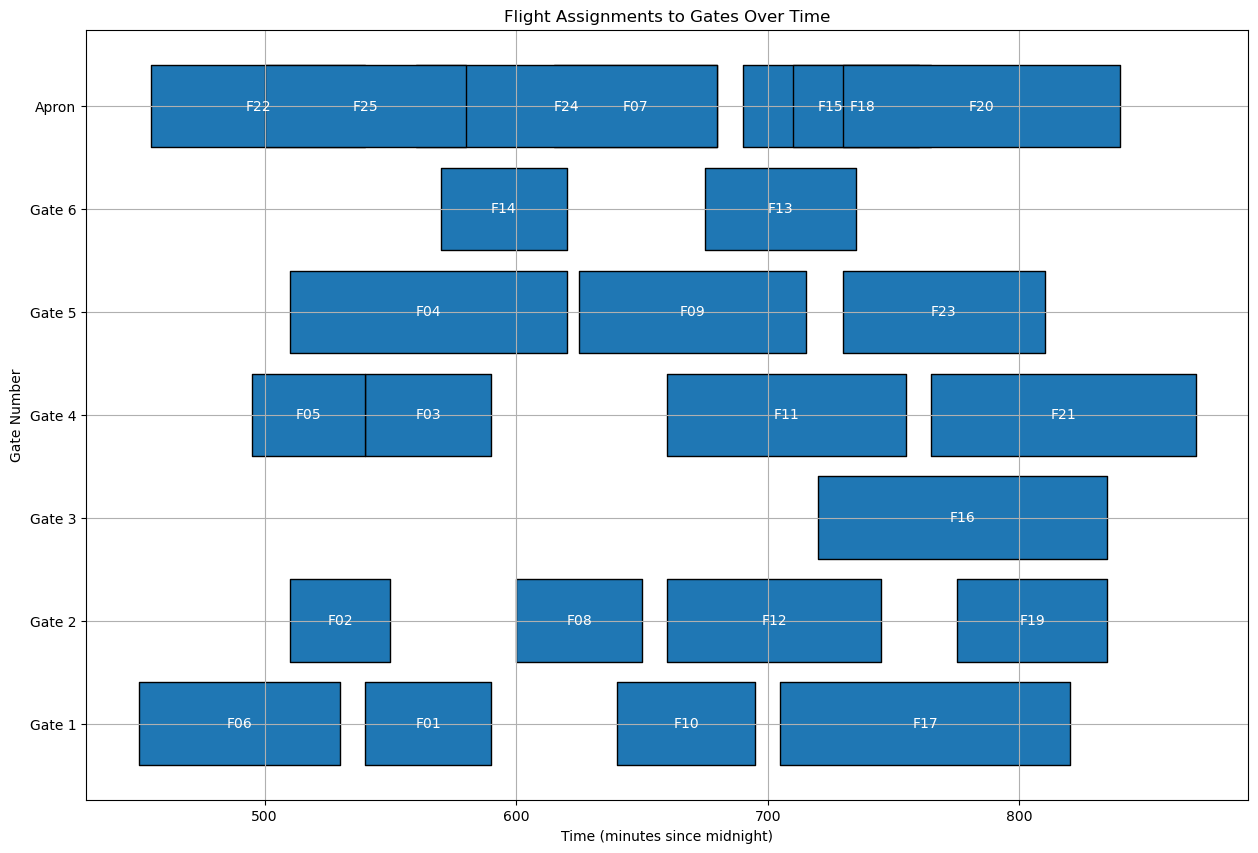

In [32]:
# Optimize model
model.optimize()

# Create a dictionary to store flight assignments
flight_assignments_img = {}
flight_assignments = {}

# Collect flight assignments to gates
if model.status == GRB.OPTIMAL:
    for i in range(num_flights):
        for k in range(num_gates + 1):
            if x[i, k].X > 0.5:  # Check if the flight is assigned to the gate
                gate = 'Apron' if k == num_gates else gate_ids[k]
                flight_assignments[f"F{i+1:02d}"] = k + 1  # Store gate number (1-indexed)
                flight_assignments_img[flight_data.loc[i, 'flight_id']] = {
                    'gate': gate,
                    'arrival_time': flight_data.loc[i, 'arrival_time'],
                    'departure_time': flight_data.loc[i, 'departure_time']
                }
    
    # Plot the flight assignments
    fig, ax = plt.subplots(figsize=(15, 10))

    for flight_id, info in flight_assignments_img.items():
        gate = info['gate']
        arrival_time = info['arrival_time']
        departure_time = info['departure_time']
        gate_num = gate_ids.index(gate) + 1 if gate != 'Apron' else num_gates + 1

        ax.broken_barh([(arrival_time, departure_time - arrival_time)], (gate_num - 0.4, 0.8),
                       facecolors=('tab:blue'), edgecolors=('black'))
        ax.text((arrival_time + departure_time) / 2, gate_num, flight_id,
                ha='center', va='center', color='white')

    # Set labels and title
    ax.set_xlabel('Time (minutes since midnight)')
    ax.set_ylabel('Gate Number')
    ax.set_title('Flight Assignments to Gates Over Time')
    ax.set_yticks(range(1, num_gates + 2))
    ax.set_yticklabels(gate_ids + ['Apron'])
    ax.grid(True)

    plt.show()
else:
    print("No optimal solution found.")


In [33]:
# Optimize model
model.optimize()

# Objective function components
transfer_distance_component = quicksum(d_kl[k, l] * w[i, k, l] for i in range(num_flights) for k in range(num_gates + 1) for l in range(num_gates + 1))
normal_distance_component = quicksum((e_i[i] + f_i[i]) * ed_k[k] * x[i, k] for i in range(num_flights) for k in range(num_gates + 1))

if model.status == GRB.OPTIMAL:
    transfer_distance = 0
    normal_distance = 0
    apron_count = 0
    
    for i in range(num_flights):
        for k in range(num_gates + 1):
            for l in range(num_gates + 1):
                if w[i, k, l].X > 0:
                    transfer_distance += d_kl[k, l] * w[i, k, l].X

    for i in range(num_flights):
        for k in range(num_gates + 1):
            if x[i, k].X > 0.5:
                normal_distance += (e_i[i] + f_i[i]) * ed_k[k] * x[i, k].X
                if k == num_gates:  # Check if assigned to apron
                    apron_count += 1

    print(f"\nObjective Transfer Distance Component: {transfer_distance}")
    print(f"Objective Normal Distance Component: {normal_distance}")
    print(f"Objective Function Value: {model.objVal}")
    print(f"Number of flights assigned to the apron: {apron_count}")

else:
    print("No optimal solution found.")

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 3465 rows, 1400 columns and 8972 nonzeros
Model fingerprint: 0x02404809
Variable types: 1225 continuous, 175 integer (175 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [2e+00, 2e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Presolved: 338 rows, 835 columns, 2164 nonzeros

Continuing optimization...


Cutting planes:
  Gomory: 10
  Implied bound: 19
  MIR: 33
  Flow cover: 83
  RLT: 5
  Relax-and-lift: 11

Explored 1 nodes (399 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 12 (of 12 available processors)

Solution count 6: 80314 85265 89562 ... 208165

Optimal solution found (tolerance 1.00e-04)
Best objective 8.031400000000e+04, be